# 23 Forecasting LSTM

In [1]:
import numpy as np 
import torch 
import torch.nn as nn 
import torch.optim as optim 
import matplotlib.pyplot as plt

In [2]:
N = 100 
L = 1000 
T = 20 

In [5]:
x = np.empty((N, L), dtype=np.float32)
x[:] = np.array(range(L) + np.random.randint(-4*T, 4*T, N).reshape(N, 1))
y = np.sin(x/1.0/T).astype(np.float32)

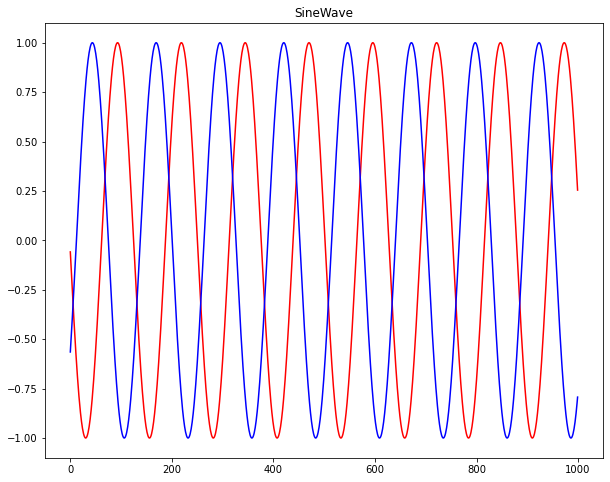

In [14]:
plt.figure(figsize=(10, 8))
plt.title('SineWave')
plt.plot(np.arange(x.shape[1]), y[0,:], 'r')
plt.plot(np.arange(x.shape[1]), y[1,:], 'b')
plt.show()

In [16]:
class LSTMPredictor(nn.Module):
    def __init__(self, n_hidden=51):
        super(LSTMPredictor, self).__init__()
        self.n_hidden = n_hidden 
        self.lstm1 = nn.LSTMCell(1, n_hidden)
        self.lstm2 = nn.LSTMCell(n_hidden, n_hidden)
        self.linear = nn.Linear(n_hidden, 1)
        
    def forward(self, x, future=0):
        outputs = []
        nsamples = x.size(0)
        
        ht = torch.zeros(nsamples, self.n_hidden, dtype=torch.float32)
        ct = torch.zeros(nsamples, self.n_hidden, dtype=torch.float32)
        ht2 = torch.zeros(nsamples, self.n_hidden, dtype=torch.float32)
        ct2 = torch.zeros(nsamples, self.n_hidden, dtype=torch.float32)
        
        for input_t in x.split(1, dim=1):
            ht, ct = self.lstm1(input_t, (ht, ct))
            ht2, ct2 = self.lstm2(ht, (ht2, ct2))
            output = self.linear(ht2)
            outputs.append(output)
            
        for _ in range(future):
            ht, ct = self.lstm1(output, (ht, ct))
            ht2, ct2 = self.lstm2(ht, (ht2, ct2))
            output = self.linear(ht2)
            outputs.append(output)
            
        outputs = torch.cat(outputs, dim=1)
        return outputs

In [17]:
train_input = torch.from_numpy(y[3:, :-1])
train_target = torch.from_numpy(y[3:, 1:])

test_input = torch.from_numpy(y[:3, :-1])
test_target = torch.from_numpy(y[:3, 1:])

In [42]:
model = LSTMPredictor()
criteria = nn.MSELoss()
optimizer = optim.LBFGS(model.parameters(), lr=0.8)

Step:  1
Step:  2


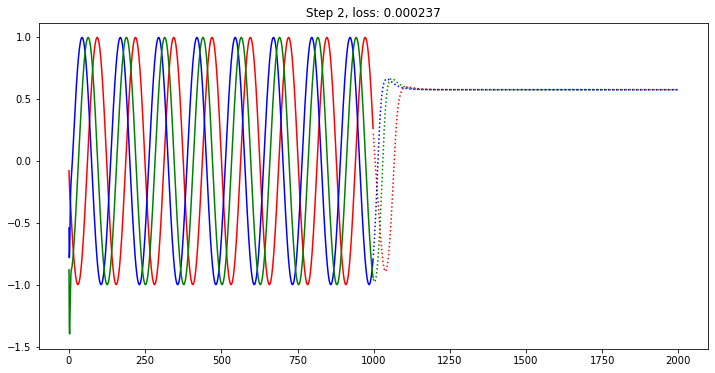

Step:  3
Step:  4


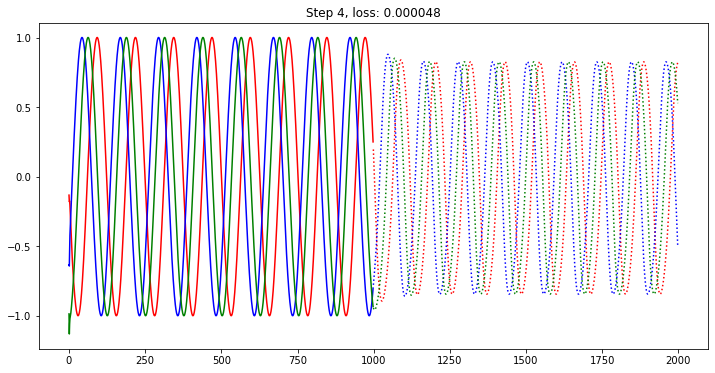

Step:  5
Step:  6


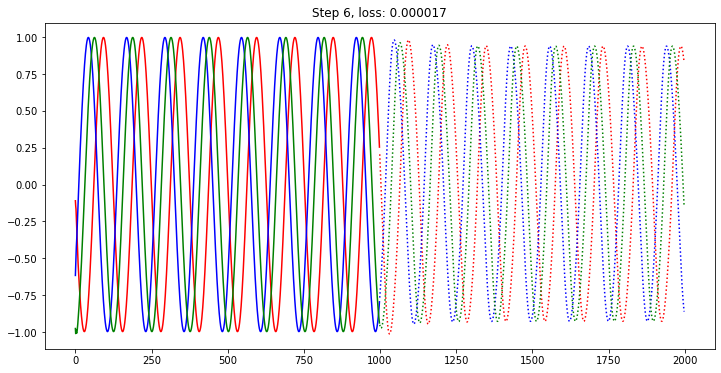

Step:  7
Step:  8


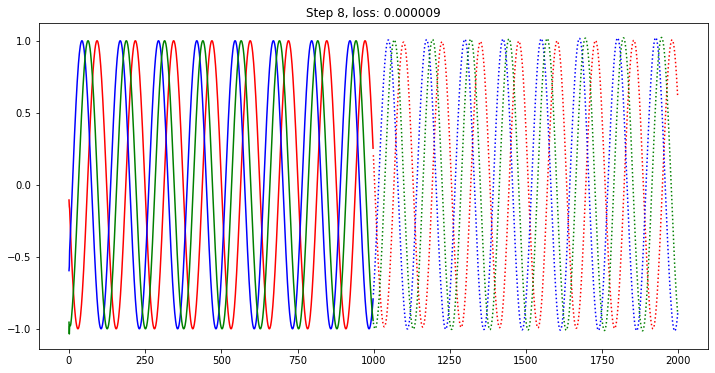

Step:  9
Step: 10


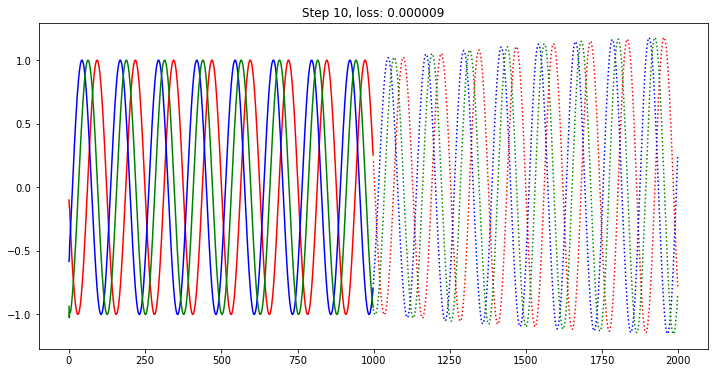

In [43]:
nsteps = 10
for k in range(nsteps):
    print(f'Step: {k+1:2d}')
    
    def closure():
        optimizer.zero_grad()
        out = model(train_input)
        loss = criteria(out, train_target)
        loss.backward()
        return loss
    
    optimizer.step(closure)
    
    if k % 2 == 0: continue
    with torch.no_grad():
        future = 1000
        pred = model(test_input, future=future)
        loss = criteria(pred[:, :-future], test_target)
        y = pred.detach().numpy()
    plt.figure(figsize=(12, 6))
    plt.title(f'Step {k+1}, loss: {loss.item():.6f}')
    n = train_input.shape[1]
    def draw(yi, color):
        plt.plot(np.arange(n), yi[:n], color)
        plt.plot(np.arange(n, n + future), yi[n:], color + ':')
    draw(y[0], 'r')
    draw(y[1], 'b')
    draw(y[2], 'g')
    plt.show()
    
    
    
    